In [22]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import json
import pandas as pd
import numpy as np
from scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
expert_data = json.load(open("./data/experts.json", "r"))

In [4]:
dms = list(expert_data.keys())
projects = list(expert_data[dms[0]].keys())
num_criteria = len(expert_data[dms[0]][projects[0]])
print(dms, projects, num_criteria)

scale_conversion = {
    "VL": 1,
    "L": 2,
    "M": 3,
    "H": 4,
    "VH": 5
}

['DM1', 'DM2', 'DM3', 'DM4', 'DM5', 'DM6'] ['A1', 'A2', 'A3', 'A4', 'A5'] 6


In [5]:
data = []
for project in projects:
    for criteria in range(num_criteria):
        for dm in dms:
            data.append([project, criteria, dm, scale_conversion[expert_data[dm][project][criteria]]])
df = pd.DataFrame(data, columns=("Project", "Criteria", "Decisionmaker", "Value"))

In [6]:
a = df[["Criteria", "Value"]].groupby("Criteria").agg(["mean", "std"])
print(a.index)
print(a[('Value', 'mean')].tolist())
print(a[('Value', 'std')].tolist())

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64', name='Criteria')
[3.6, 3.1666666666666665, 3.6, 3.1333333333333333, 3.6666666666666665, 2.3]
[1.3544307876819288, 1.2617266038997932, 1.3796551293211172, 1.2521246311585852, 1.5161960871578068, 0.9523111632886272]


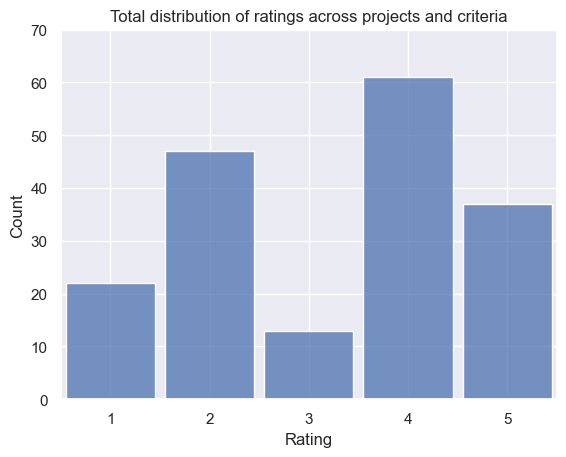

3.2444444444444445 1.3644415733010349


In [7]:
g = sns.histplot(df, x="Value", discrete=True, shrink=0.9)
g.set(xlabel=f"Rating", ylim=(0, 70), xlim=(0.5, 5.5), title="Total distribution of ratings across projects and criteria")
plt.show()
mean, std =df["Value"].mean(), df["Value"].std()
print(mean, std)

Text(0.5, 0.98, 'Expert rating distribution no prior')

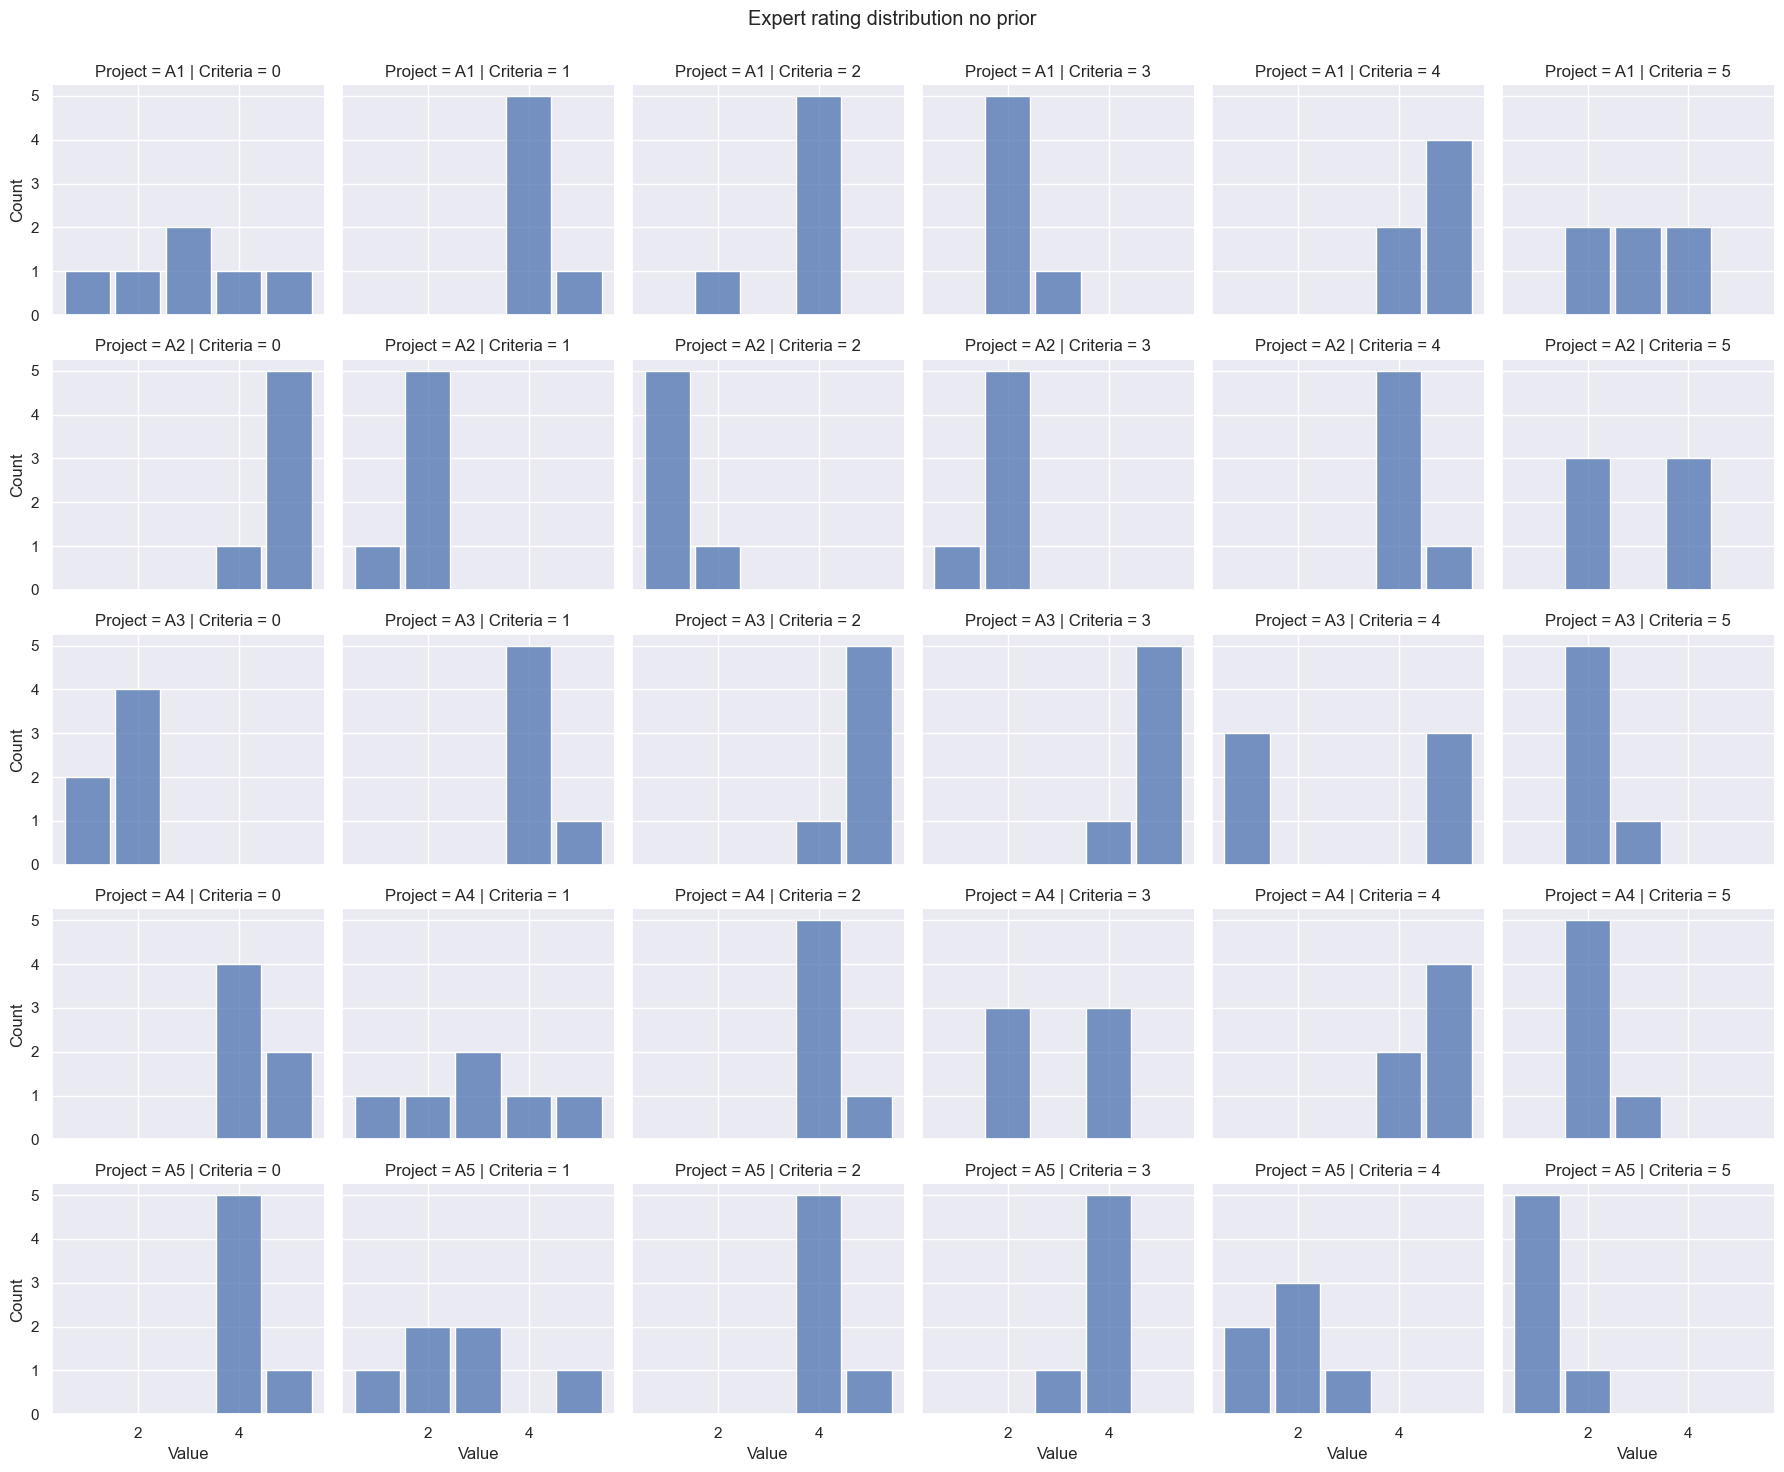

In [8]:
g = sns.FacetGrid(df, col="Criteria", row="Project")
g.map_dataframe(sns.histplot, x="Value", discrete=True, shrink=0.9)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle("Expert rating distribution no prior")

Text(0.5, 0.98, 'Ground truth estimation from expert guesses')

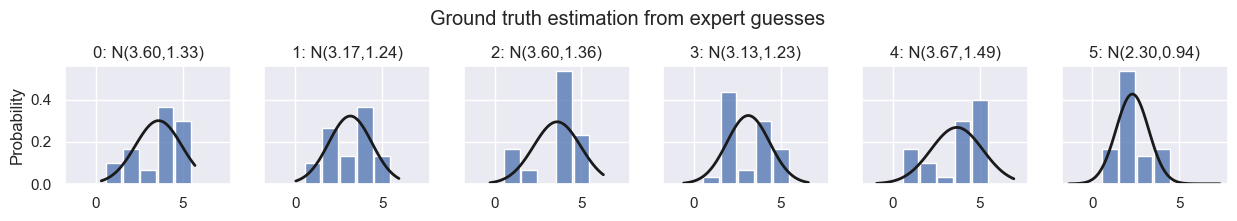

In [34]:
fig, axes = plt.subplots(1,num_criteria, figsize=(15,2), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_criteria):
    values = df[df["Criteria"]==i]["Value"].to_numpy()
    mu = np.mean(values)
    std = np.std(values)
    g = sns.histplot(values, discrete=True, shrink=0.9, stat="probability", ax=axes[i])
    xmin, xmax = g.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i].plot(x, p, 'k', linewidth=2)
    axes[i].set_title(f"{i}: N({mu:.2f},{std:.2f})")

fig.subplots_adjust(top=0.7)
fig.suptitle("Ground truth estimation from expert guesses")

Text(0.5, 0.98, 'Range of ratings per criteria')

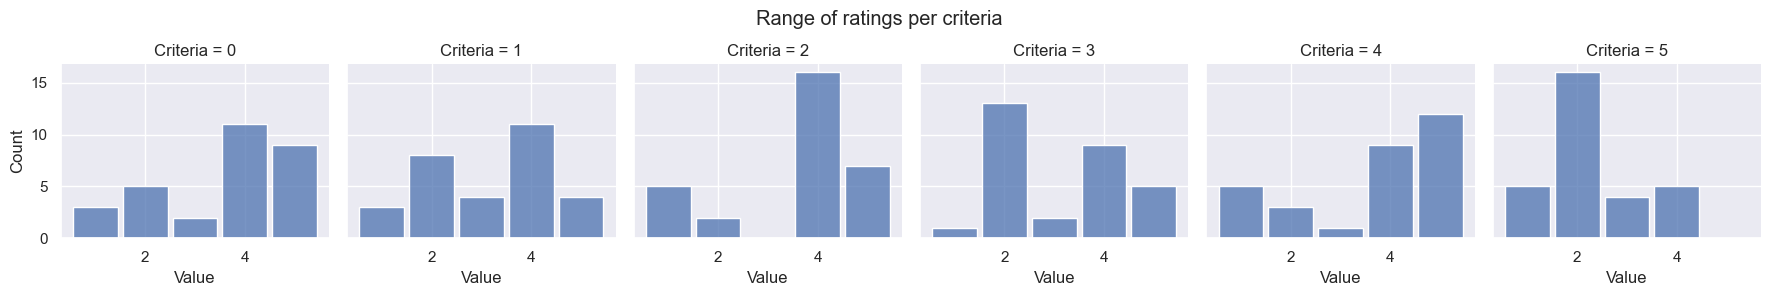

In [9]:
g = sns.FacetGrid(df, col="Criteria")
g.map_dataframe(sns.histplot, x="Value", discrete=True, shrink=0.9)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Range of ratings per criteria")



In [10]:
project_data = {}
for project in projects:
    project_dict = {}
    for criteria in range(num_criteria):
        values = []
        for dm in dms:
            values.append(scale_conversion[expert_data[dm][project][criteria]])
        project_dict[criteria] = values
    project_data[project] = project_dict


In [11]:
weights = [0.0206795, 0.0672084, 0.2227102, 0.1067428, 0.4665054, 0.1161537]

for project in projects:
    value = 0
    for criteria, weight in enumerate(weights):
        value += weight*np.mean(project_data[project][criteria])
    print(f"Project {project} = {np.round(value,2)}")

Project A1 = 3.92
Project A2 = 2.97
Project A3 = 3.56
Project A4 = 3.97
Project A5 = 2.59


Text(0.5, 0.98, 'Distance to mean expert ration per expert')

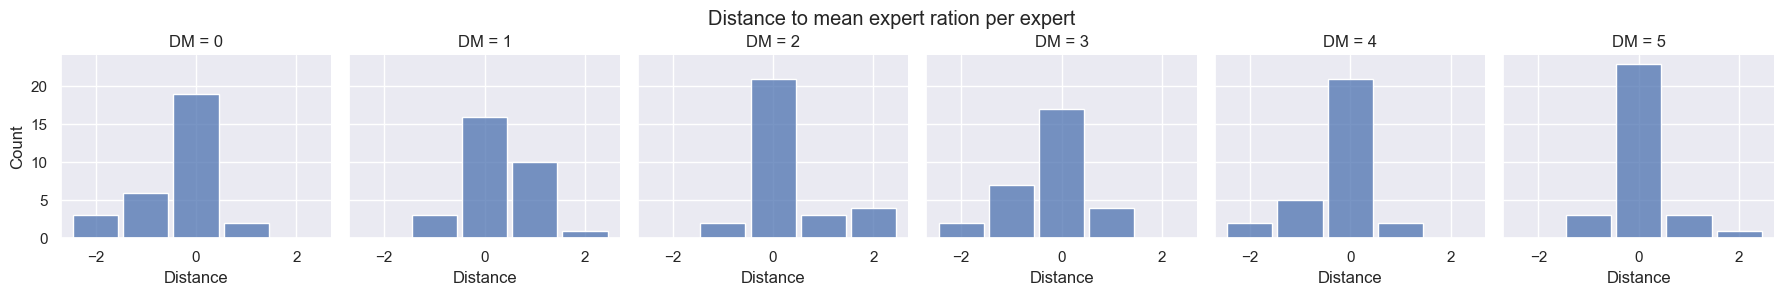

In [12]:
# Distance to mean per dm
dm_data = []
for project in projects:
    for criteria, weight in enumerate(weights):
        mean = np.mean(project_data[project][criteria])
        for i in range(len(dms)):
            distance = round(project_data[project][criteria][i] - mean)
            dm_data.append([i, distance])
dm_df = pd.DataFrame(dm_data, columns=["DM", "Distance"])

g = sns.FacetGrid(dm_df, col="DM")
g.map_dataframe(sns.histplot, x="Distance", discrete=True, shrink=0.9)
g.fig.subplots_adjust(top=0.83)
g.fig.suptitle("Distance to mean expert ration per expert")

In [38]:
# Assume uniform prior - add 1 when calculating ground truth probabilities
prior_data = []
for project in projects:
    for criteria, weight in enumerate(weights):
        for value in range(1, 6):
            prior_data.append([project, criteria, -1, value])
prior_df = pd.DataFrame(prior_data, columns=("Project", "Criteria", "Decisionmaker", "Value"))
combined_df = pd.concat([df, prior_df])

Text(0.5, 0.98, 'Distance to mean expert ration per expert')

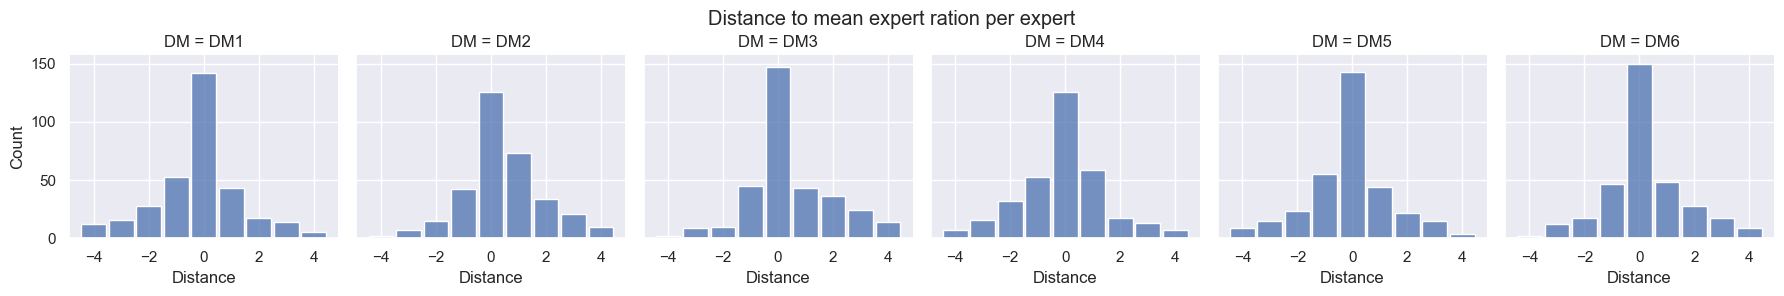

In [36]:
g = sns.FacetGrid(dm_df, col="DM")
g.map_dataframe(sns.histplot, x="Distance", discrete=True, shrink=0.9)
g.fig.subplots_adjust(top=0.83)
g.fig.suptitle("Distance to mean expert ration per expert")

Text(0.5, 0.98, 'Expert rating distribution uniform prior')

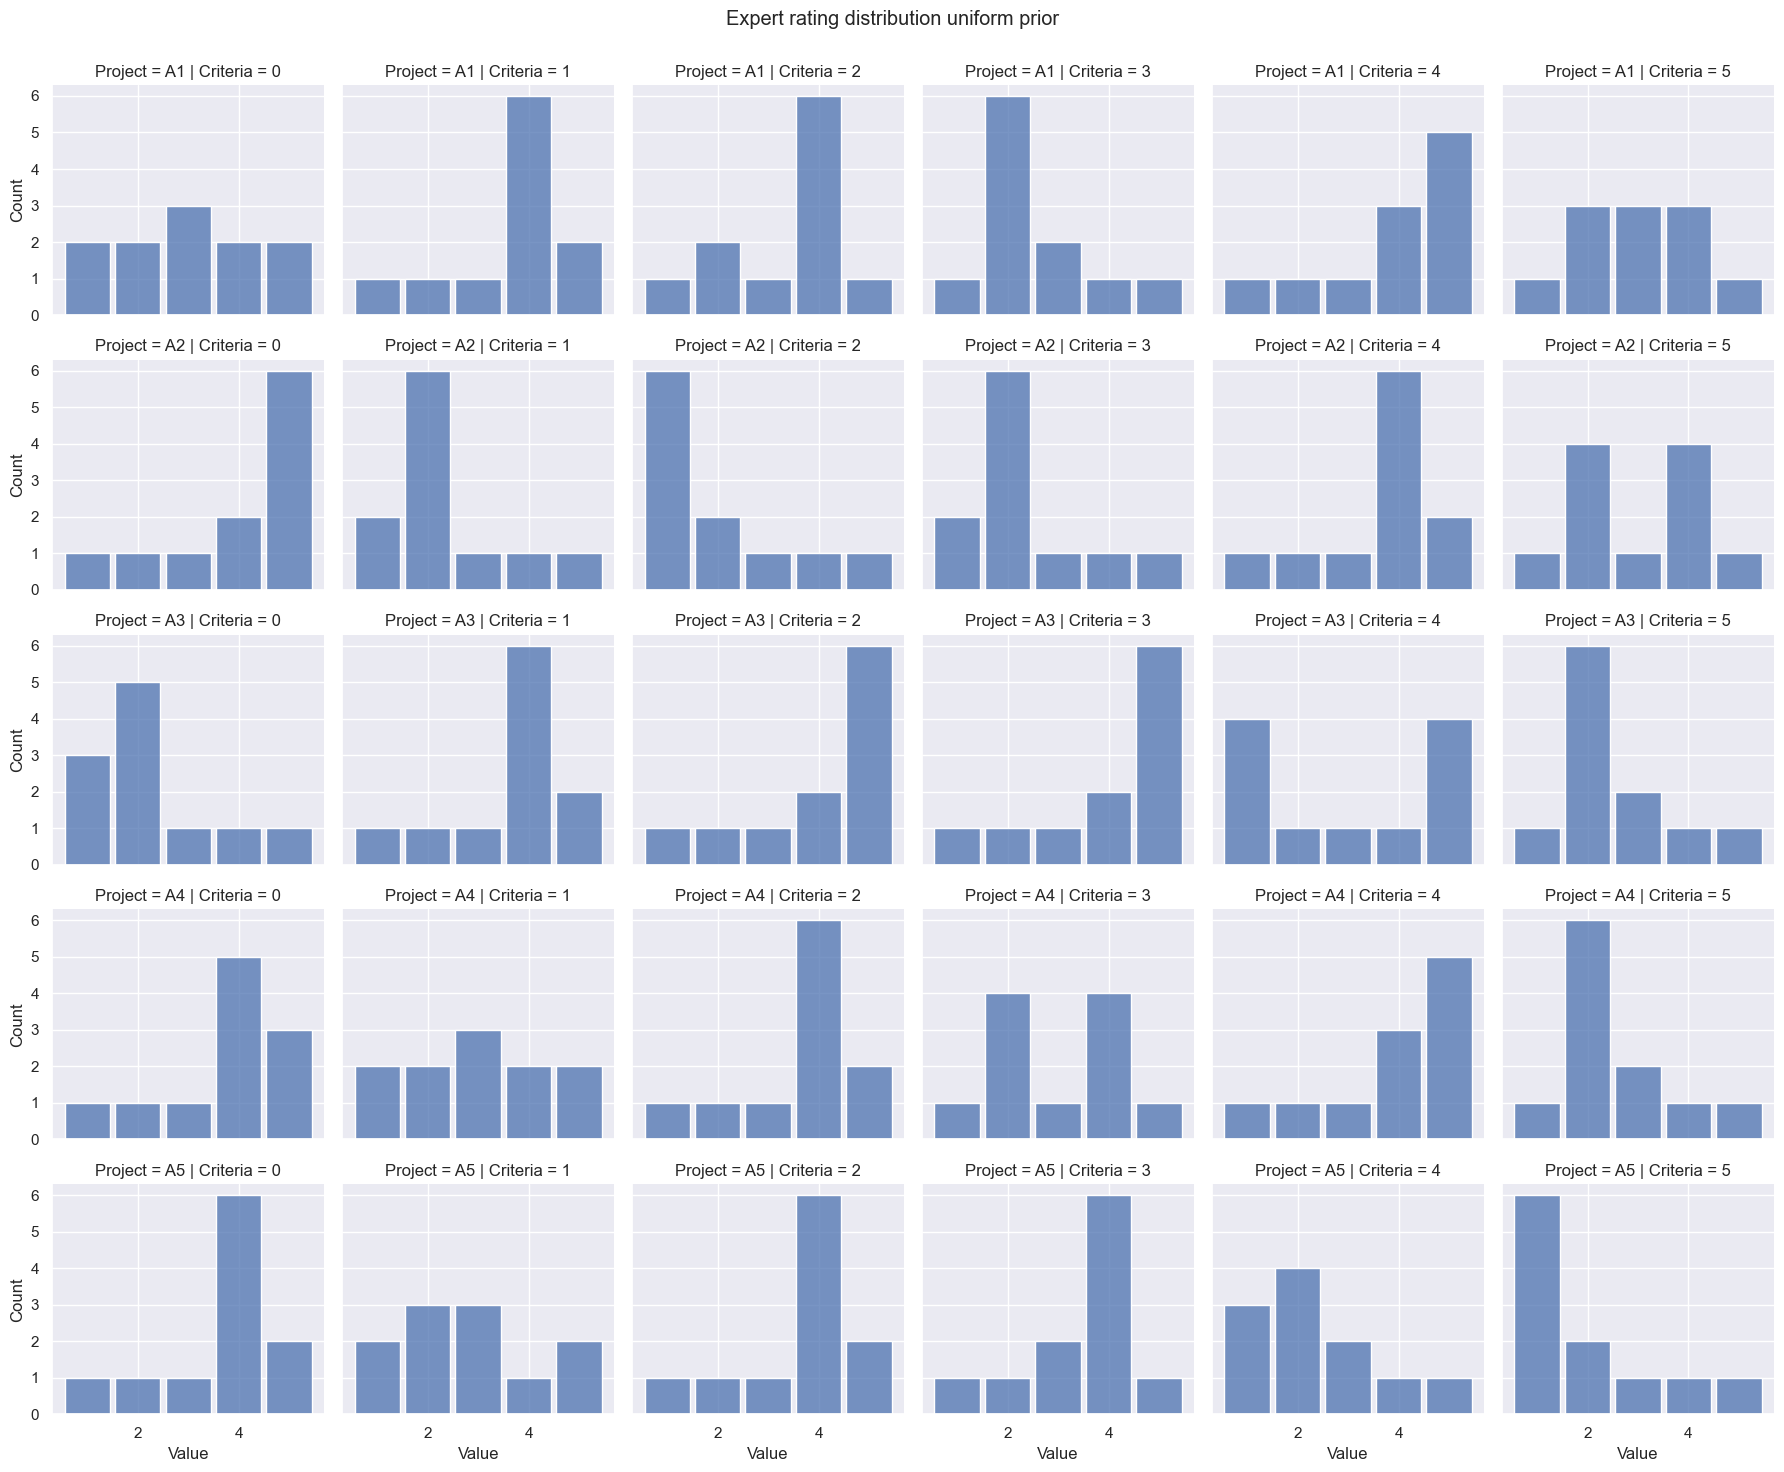

In [14]:
g = sns.FacetGrid(combined_df, col="Criteria", row="Project")
g.map_dataframe(sns.histplot, x="Value", discrete=True, shrink=0.9)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle("Expert rating distribution uniform prior")

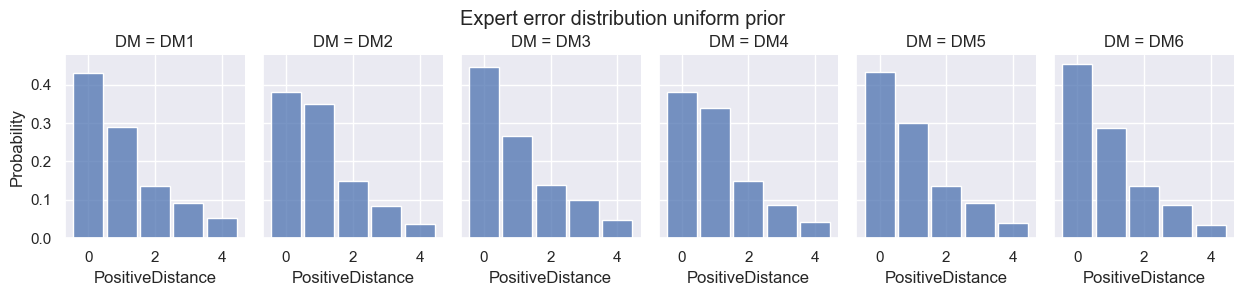

In [39]:
def get_error_distances(df, project="A1", criteria=0, dm="DM1"):
    guess = df[(df["Project"]==project) & (df["Criteria"]==criteria) & (df["Decisionmaker"]==dm)]["Value"].item()
    outcomes = df[(df["Project"]==project) & (df["Criteria"]==criteria)]
    distances = guess - outcomes["Value"].to_numpy()
    return distances

dm_data = []
for project in projects:
    for criteria, weight in enumerate(weights):
        for dm in dms:
            distances = get_error_distances(combined_df, project, criteria, dm)
            for distance in distances:
                dm_data.append([dm, distance])
dm_df = pd.DataFrame(dm_data, columns=["DM", "Distance"])
dm_df["PositiveDistance"] = np.abs(dm_df["Distance"])

g = sns.FacetGrid(dm_df, col="DM", aspect=0.7)
g.map_dataframe(sns.histplot, x="PositiveDistance", discrete=True, shrink=0.9, stat="probability")
g.fig.subplots_adjust(top=0.83)
g.fig.suptitle("Expert error distribution uniform prior")
plt.show()

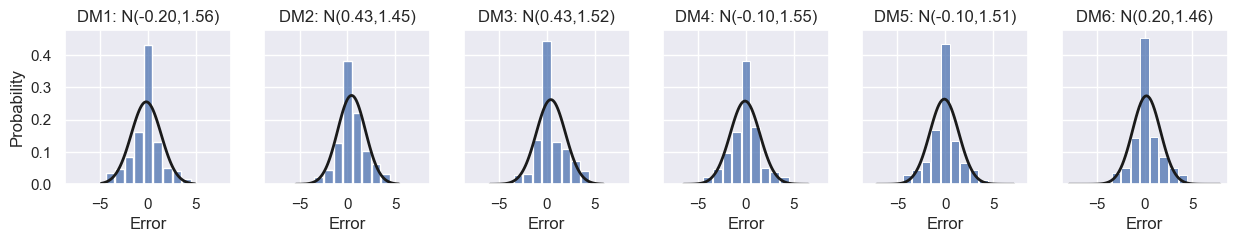

In [40]:
# Fit normal distribution to dm data
from scipy.stats import norm

fig, axes = plt.subplots(1,len(dms), figsize=(15,2), sharex=True, sharey=True)
axes = axes.flatten()
expert_stds = []

for i, dm in enumerate(dms):
    distances = dm_df[dm_df["DM"]==dm]["Distance"].to_numpy()
    mu = np.mean(distances)
    std = np.std(distances)
    expert_stds.append(std)
    g = sns.histplot(distances, discrete=True, shrink=0.9, stat="probability", ax=axes[i])
    xmin, xmax = g.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i].plot(x, p, 'k', linewidth=2)
    axes[i].set_title(f"{dm}: N({mu:.2f},{std:.2f})")
    axes[i].set_xlabel("Error")

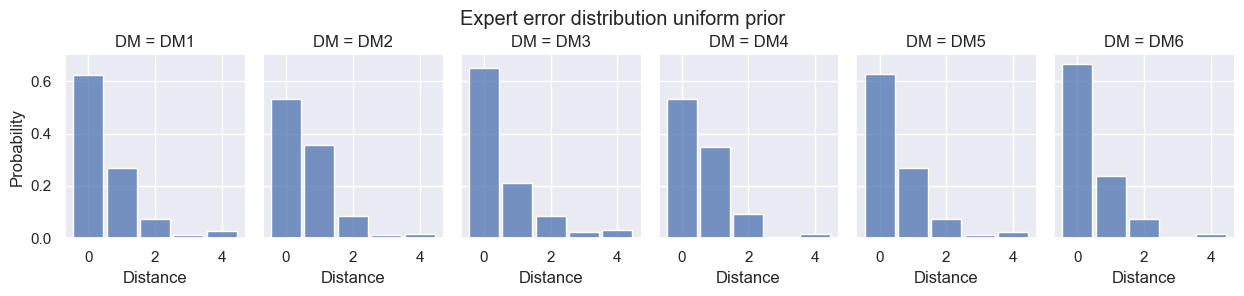

In [19]:
dm_data = []
for project in projects:
    for criteria, weight in enumerate(weights):
        for dm in dms:
            distances = get_error_distances(df, project, criteria, dm)
            for distance in distances:
                dm_data.append([dm, distance])
dm_df = pd.DataFrame(dm_data, columns=["DM", "Distance"])

g = sns.FacetGrid(dm_df, col="DM", aspect=0.7)
g.map_dataframe(sns.histplot, x="Distance", discrete=True, shrink=0.9, stat="probability")
g.fig.subplots_adjust(top=0.83)
g.fig.suptitle("Expert error distribution uniform prior")
plt.show()

In [4]:
#expert cost: $1500-$5000
# stake $10 000 000
expert_cost = 5000
stakes = 10000000
expected_reward = 3.401163603333334
cost_to_reward = expert_cost / stakes
click_cost = cost_to_reward * expected_reward
print("Click cost:", round(click_cost,4))

Click cost: 0.0017


In [ ]:
(expert_cost / stakes) * expected_termination_reward